<a href="https://colab.research.google.com/github/Graner2002/TinyML-Gym-Exercise-Classification-Thesis/blob/main/tf_exercise_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot **Data**

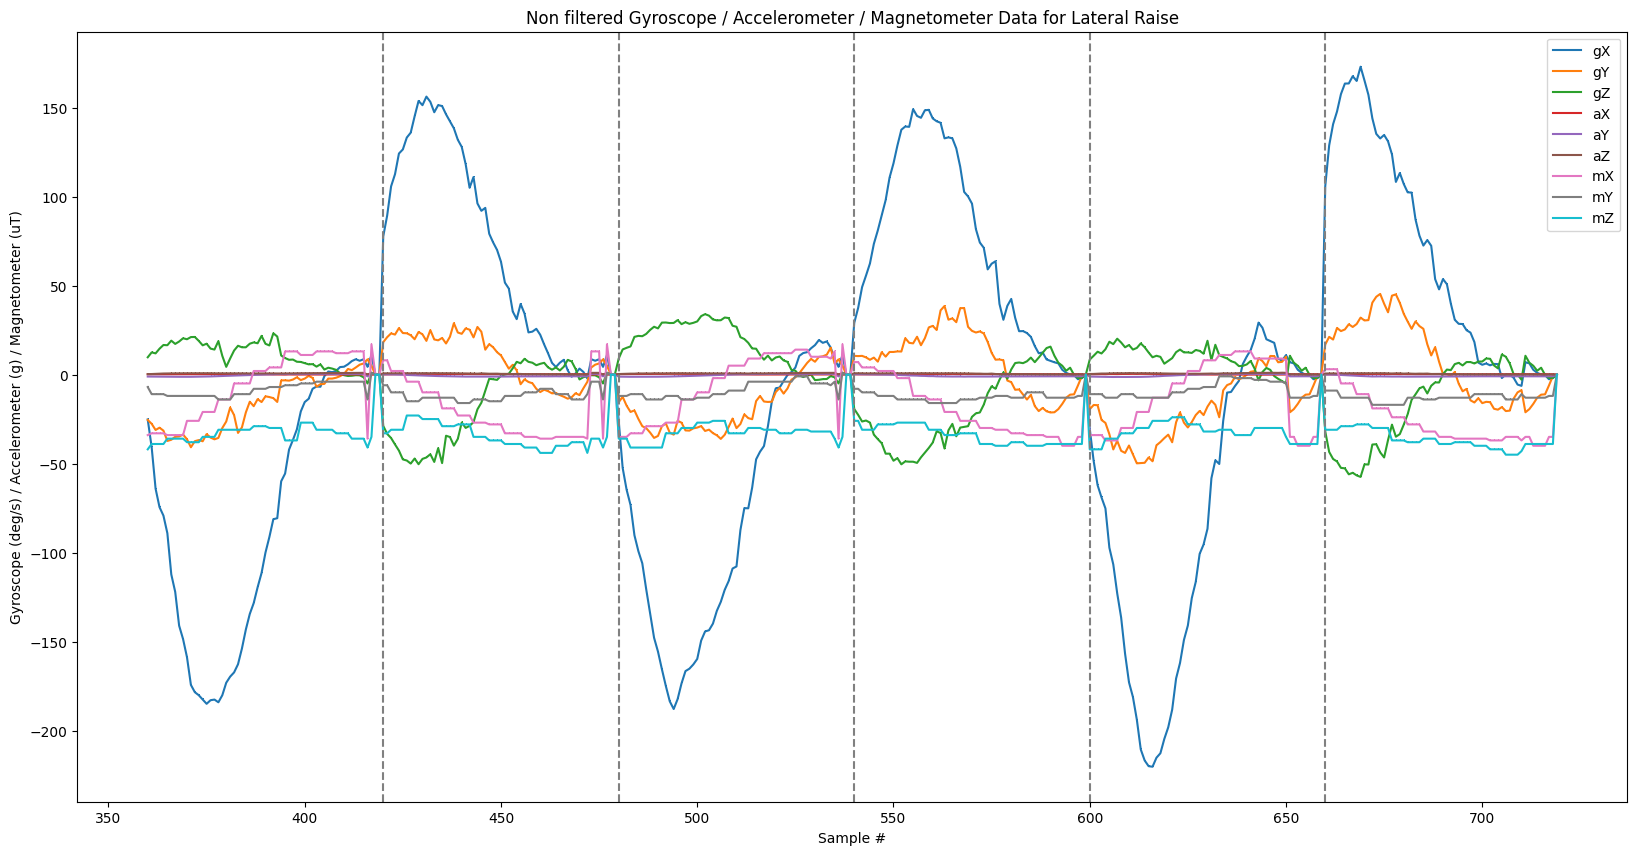

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def moving_average(data, window_size=10):
    data_filtered = np.zeros_like(data)
    for i in range(len(data)):
        start = max(0, i - window_size + 1)
        end = i + 1
        data_filtered[i] = np.mean(data[start:end])
    return data_filtered

def plot_data(df, index, samples_per_gesture, start_gesture, title):
    plt.rcParams["figure.figsize"] = (20, 10)

    plt.plot(index, df['gX'], color='tab:blue', label='gX', linestyle='solid', marker=',')
    plt.plot(index, df['gY'], color='tab:orange', label='gY', linestyle='solid', marker=',')
    plt.plot(index, df['gZ'], color='tab:green', label='gZ', linestyle='solid', marker=',')

    plt.plot(index, df['aX'], color='tab:red', label='aX', linestyle='solid', marker=',')
    plt.plot(index, df['aY'], color='tab:purple', label='aY', linestyle='solid', marker=',')
    plt.plot(index, df['aZ'], color='tab:brown', label='aZ', linestyle='solid', marker=',')

    plt.plot(index, df['mX'], color='tab:pink', label='mX', linestyle='solid', marker=',')
    plt.plot(index, df['mY'], color='tab:gray', label='mY', linestyle='solid', marker=',')
    plt.plot(index, df['mZ'], color='tab:cyan', label='mZ', linestyle='solid', marker=',')

    for i in range(1, len(index) // samples_per_gesture):
      plt.axvline(x=start_gesture * samples_per_gesture + i * samples_per_gesture, color='gray', linestyle='--')

    plt.title(title)
    plt.xlabel("Sample #")
    plt.ylabel("Gyroscope (deg/s) / Accelerometer (g) / Magnetometer (uT)")
    plt.legend()
    plt.show()

filename = "lateral_raise.csv"

df = pd.read_csv("/content/drive/MyDrive/TFG/Training Data/Home Gym Ble Data 2/Normal/" + filename)

SAMPLES_PER_GESTURE = 60
NUM_OF_GESTURES = 6
start_gesture = 6

start_index = SAMPLES_PER_GESTURE * start_gesture
end_index = SAMPLES_PER_GESTURE * (start_gesture + NUM_OF_GESTURES)
index = range(start_index, end_index)

df_subset = df.iloc[start_index:end_index]

for column in df.columns:
    df[column] = moving_average(df[column].values)

filtered_data = df.iloc[start_index:end_index]

exercise = "Lateral Raise"
title = "Non filtered Gyroscope / Accelerometer / Magnetometer Data for " + exercise

plot_data(df_subset, index, SAMPLES_PER_GESTURE, start_gesture, title)

# **Split Data**

In [ ]:
import pandas as pd

#filename = "shoulder_press.csv"
#filename = "bent_row.csv"
#filename = "biceps_curl.csv"
#filename = "lateral_raise.csv"
#filename = "skull_crusher.csv"

directory = "/content/drive/MyDrive/TFG/Training Data/Home Gym Ble Data 2/Normal/"

# Read the CSV file
df = pd.read_csv(directory + filename)

# Split the dataframe into blocks of 90 samples
blocks = [df[i:i+60] for i in range(0, len(df), 60)]

# Define the first and second halves
first_half = blocks[::2]
second_half = blocks[1::2]

# Write the first half to a new CSV file
with open(directory + filename.replace(".csv", "_first_half.csv"), "w") as f:
    # Write the header
    f.write(",".join(df.columns) + "\n")
    for block in first_half:
        block.to_csv(f, index=False, header=False)
        f.write("\n")

# Write the second half to a new CSV file
with open(directory + filename.replace(".csv", "_second_half.csv"), "w") as f:
    # Write the header
    f.write(",".join(df.columns) + "\n")
    for block in second_half:
        block.to_csv(f, index=False, header=False)
        f.write("\n")

# **Preprocess and prepare data**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "shoulder_press_half",
    "bent_row_half",
    "biceps_curl_first_half",
    "biceps_curl_second_half",
    "lateral_raise_first_half",
    "lateral_raise_second_half",
    "triceps_extention_first_half",
    "triceps_extention_second_half"
]

directories = [
    "/content/drive/MyDrive/TFG/Training Data/Home Gym Ble Data/normal/",
    "/content/drive/MyDrive/TFG/Training Data/Home Gym Ble Data/fast/"
]

SAMPLES_PER_GESTURE = 60
NUM_GESTURES = len(GESTURES)
window_size = 10

def moving_average(data, window_size):
    data_filtered = np.zeros_like(data)
    for i in range(len(data)):
        start = max(0, i - window_size + 1)
        end = i + 1
        data_filtered[i] = np.mean(data[start:end])
    return data_filtered

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

dfs = [pd.DataFrame() for _ in range(NUM_GESTURES)]

for directory in directories:
  for gesture_index in range(NUM_GESTURES):
    gesture = GESTURES[gesture_index]
    file_path = os.path.join(directory, gesture + ".csv")

    if os.path.exists(file_path):
      df = pd.read_csv(file_path)
      dfs[gesture_index] = pd.concat([dfs[gesture_index], df], ignore_index=True)


# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = dfs[gesture_index]

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  for i in range(num_recordings):
    start_index = i * SAMPLES_PER_GESTURE
    end_index = (i + 1) * SAMPLES_PER_GESTURE
    df['aX'][start_index:end_index] = moving_average(df['aX'][start_index:end_index],window_size)
    df['aY'][start_index:end_index] = moving_average(df['aY'][start_index:end_index],window_size)
    df['aZ'][start_index:end_index] = moving_average(df['aZ'][start_index:end_index],window_size)
    df['gX'][start_index:end_index] = moving_average(df['gX'][start_index:end_index],window_size)
    df['gY'][start_index:end_index] = moving_average(df['gY'][start_index:end_index],window_size)
    df['gZ'][start_index:end_index] = moving_average(df['gZ'][start_index:end_index],window_size)
    df['mX'][start_index:end_index] = moving_average(df['mX'][start_index:end_index],window_size)
    df['mY'][start_index:end_index] = moving_average(df['mY'][start_index:end_index],window_size)
    df['mZ'][start_index:end_index] = moving_average(df['mZ'][start_index:end_index],window_size)

  for i in range(num_recordings):
    tensor = []

    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      # - magnetometer is between: -400 to +400
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000,
          (df['mX'][index] + 400) / 800,
          (df['mY'][index] + 400) / 800,
          (df['mZ'][index] + 400) / 800
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

TensorFlow version = 2.15.0

Processing index 0 for gesture 'shoulder_press_half'.
	There are 68 recordings of the shoulder_press_half gesture.
Processing index 1 for gesture 'bent_row_half'.
	There are 70 recordings of the bent_row_half gesture.
Processing index 2 for gesture 'biceps_curl_first_half'.
	There are 37 recordings of the biceps_curl_first_half gesture.
Processing index 3 for gesture 'biceps_curl_second_half'.
	There are 37 recordings of the biceps_curl_second_half gesture.
Processing index 4 for gesture 'lateral_raise_first_half'.
	There are 35 recordings of the lateral_raise_first_half gesture.
Processing index 5 for gesture 'lateral_raise_second_half'.
	There are 35 recordings of the lateral_raise_second_half gesture.
Processing index 6 for gesture 'triceps_extention_first_half'.
	There are 35 recordings of the triceps_extention_first_half gesture.
Processing index 7 for gesture 'triceps_extention_second_half'.
	There are 35 recordings of the triceps_extention_second_hal

# **Plot Data Distribution**

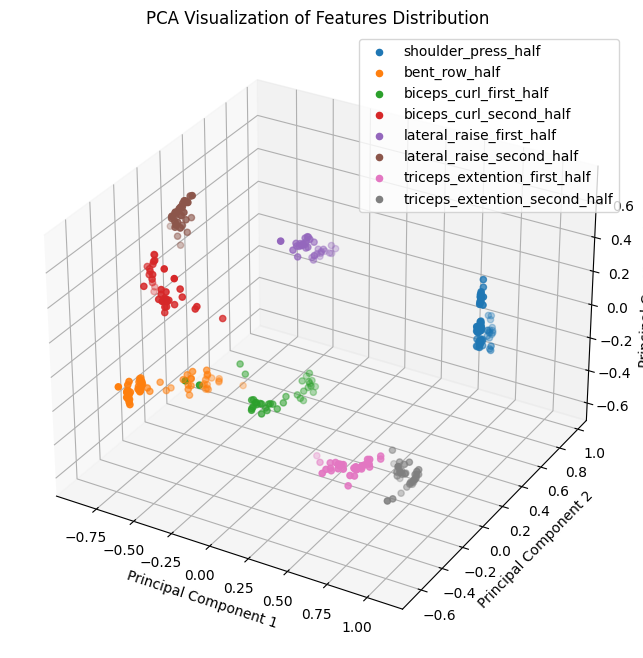

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
inputs_pca = pca.fit_transform(inputs)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(NUM_GESTURES):
  ax.scatter(inputs_pca[outputs[:, i] == 1, 0], inputs_pca[outputs[:, i] == 1, 1], inputs_pca[outputs[:, i] == 1, 2], label=GESTURES[i])
ax.set_title('PCA Visualization of Features Distribution')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

# **Train Model**

In [ ]:
# build the model and train it
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae','accuracy'])

history = model.fit(inputs_train, outputs_train, epochs=200, batch_size=1, validation_data=(inputs_validate, outputs_validate))


Epoch 1/200
211/211 [==============================] - 9s 15ms/step - loss: 0.1093 - mae: 0.2185 - accuracy: 0.1801 - val_loss: 0.1093 - val_mae: 0.2183 - val_accuracy: 0.1549
Epoch 2/200
211/211 [==============================] - 2s 9ms/step - loss: 0.1082 - mae: 0.2171 - accuracy: 0.2322 - val_loss: 0.1087 - val_mae: 0.2175 - val_accuracy: 0.1549
Epoch 3/200
211/211 [==============================] - 1s 6ms/step - loss: 0.1073 - mae: 0.2156 - accuracy: 0.2133 - val_loss: 0.1082 - val_mae: 0.2173 - val_accuracy: 0.1549
Epoch 4/200
211/211 [==============================] - 1s 7ms/step - loss: 0.1067 - mae: 0.2148 - accuracy: 0.2938 - val_loss: 0.1080 - val_mae: 0.2160 - val_accuracy: 0.1549
Epoch 5/200
211/211 [==============================] - 1s 6ms/step - loss: 0.1059 - mae: 0.2132 - accuracy: 0.2370 - val_loss: 0.1070 - val_mae: 0.2148 - val_accuracy: 0.1549
Epoch 6/200
211/211 [==============================] - 1s 6ms/step - loss: 0.1047 - mae: 0.2122 - accuracy: 0.2370 - val_los

# **Plot Loss**

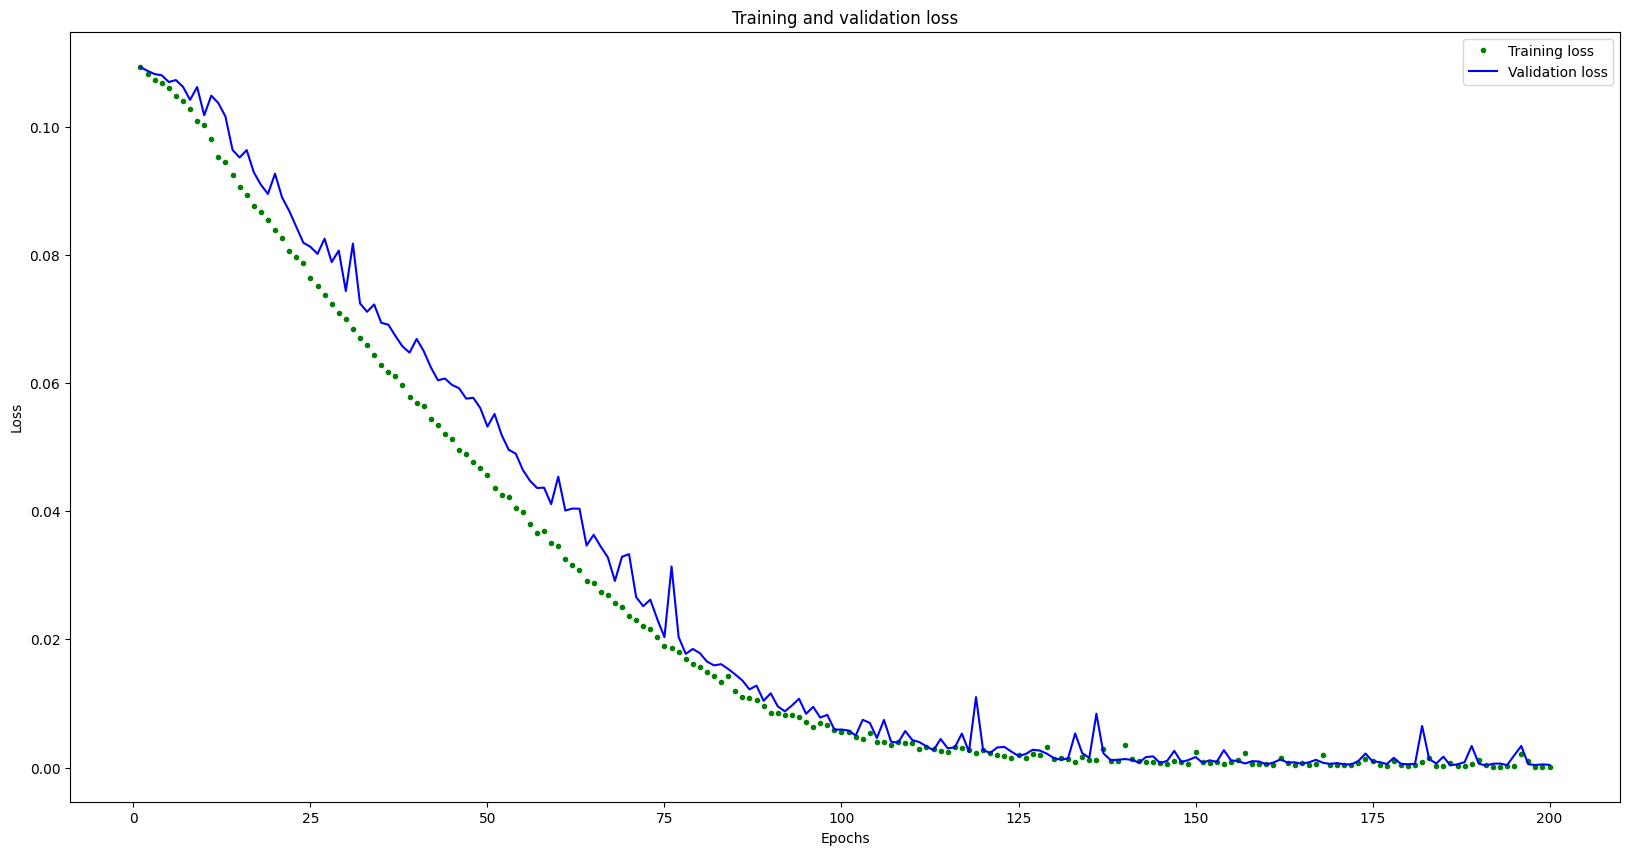

[20.0, 10.0]


In [ ]:
plt.rcParams["figure.figsize"] = (20,10)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

# **Plot Confusion Matrix**

3/3 [==============================] - 0s 4ms/step


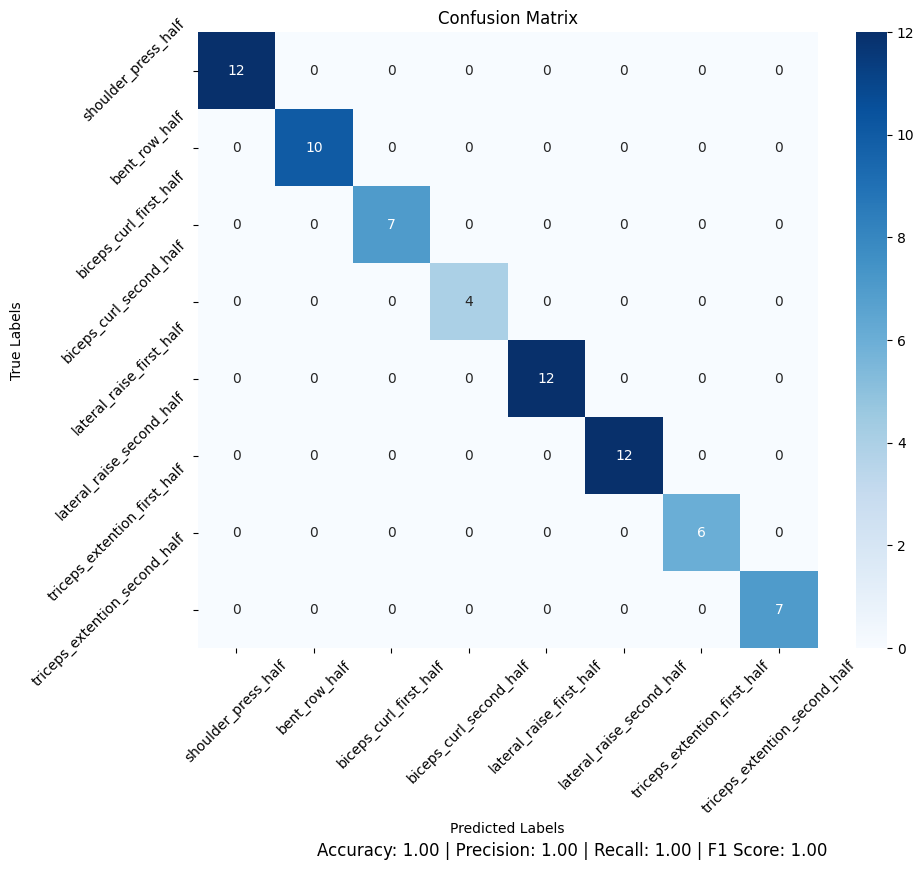

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Get predictions for the test set
predictions = model.predict(inputs_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(outputs_test, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=GESTURES, yticklabels=GESTURES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display metrics
plt.figtext(0.5, -0.15, f'Accuracy: {accuracy:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1:.2f}',
            ha='center', fontsize=12)

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# **TensorFlow Lite Conversion and Model to Byte Array**

In [ ]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Model is 124468 bytes
Header file, model.h, is 767,588 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
